In [1]:
# libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datasage.styles import DARK_THEME,LIGHT_THEME,theme
from datasage.core import Leonardo
import matplotlib.colors
import matplotlib.font_manager as fm
import mplcyberpunk
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
leo = Leonardo()
plt.style.use(LIGHT_THEME)

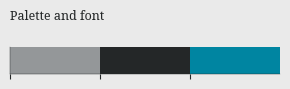

In [2]:
# settings
font_family = leo.setup_google_font()
plt.rcParams['font.family'] = font_family
# plt.rcParams['figure.dpi'] = 300

# palette
colors = ['#949799', '#242728', '#0085a1']
ccmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
sns.palplot(colors,size=1)
plt.title('Palette and font',size=9)
plt.show()

## Ipotesi Nulla e Alternativa

$H_0: \mu_1 = \mu_2 = ... = \mu_k$ (tutte le medie dei gruppi sono uguali)

$H_1:$ almeno una media è diversa dalle altre

In [3]:
df = pd.read_csv('insurance.csv')

Statistiche descrittive per regione:
           count          mean           std        min          25%  \
region                                                                 
northeast  324.0  13406.384516  11255.803066  1694.7964  5194.322288   
northwest  325.0  12417.575374  11072.276928  1621.3402  4719.736550   
southeast  364.0  14735.411438  13971.098589  1121.8739  4440.886200   
southwest  325.0  12346.937377  11557.179101  1241.5650  4751.070000   

                    50%         75%          max  
region                                            
northeast  10057.652025  16687.3641  58571.07448  
northwest   8965.795750  14711.7438  60021.39897  
southeast   9294.131950  19526.2869  63770.42801  
southwest   8798.593000  13462.5200  52590.82939  


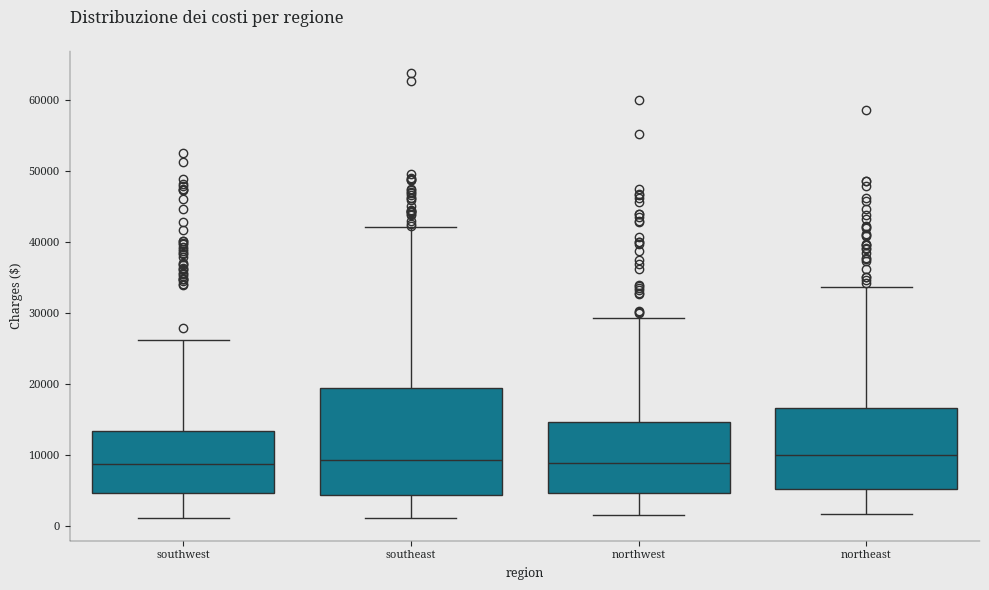


Risultati One-way ANOVA per regione:
F-statistic: 2.9696
p-value: 0.0309

Risultati test di Tukey:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------
northeast northwest  -988.8091 0.7245 -3428.9343 1451.3161  False
northeast southeast  1329.0269 0.4745 -1044.9417 3702.9955  False
northeast southwest -1059.4471 0.6792 -3499.5723 1380.6781  False
northwest southeast  2317.8361 0.0583   -54.1994 4689.8716  False
northwest southwest    -70.638 0.9999 -2508.8826 2367.6066  False
southeast southwest -2388.4741 0.0477 -4760.5096  -16.4386   True
-----------------------------------------------------------------

Risultati Two-way ANOVA:
                           sum_sq      df            F         PR(>F)
C(region)            1.075232e+08     3.0     0.652722   5.812827e-01
C(smoker)            1.203267e+11     1.0  2191.337326  1.751867e-283
C(re

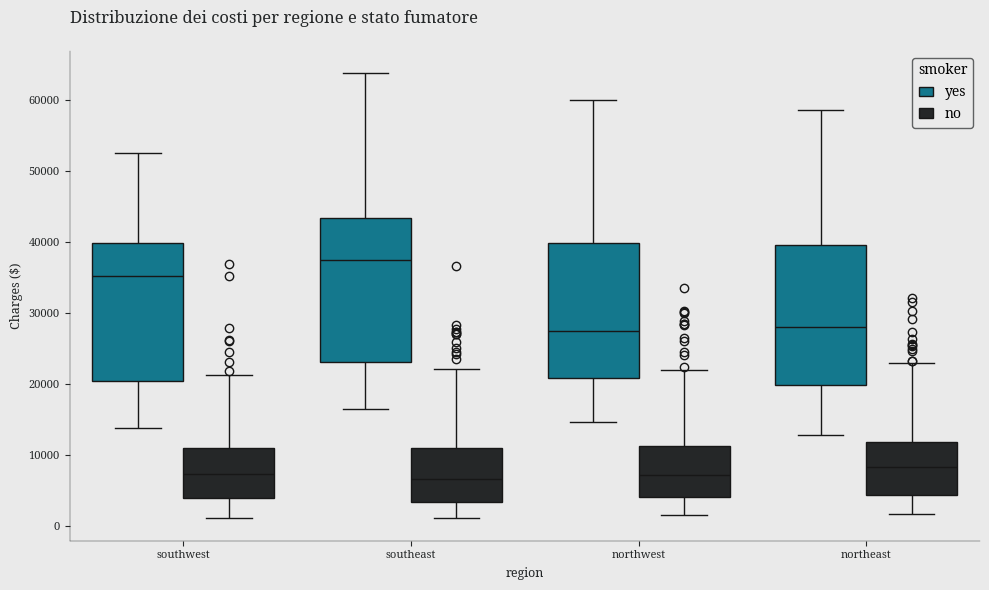

<Figure size 1000x600 with 0 Axes>

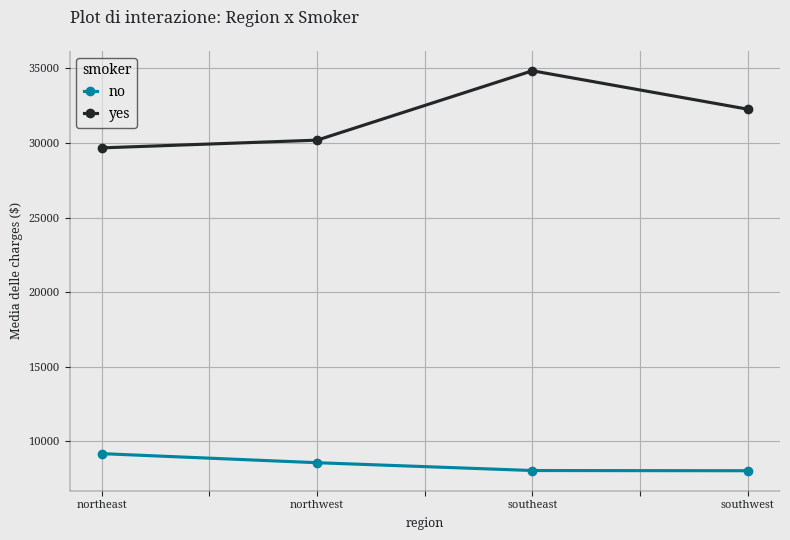


Risultati ANCOVA:
                 sum_sq      df            F        PR(>F)
C(smoker)  1.239179e+11     1.0  3028.412521  0.000000e+00
age        1.992820e+10     1.0   487.022532  2.909751e-92
Residual   5.462612e+10  1335.0          NaN           NaN


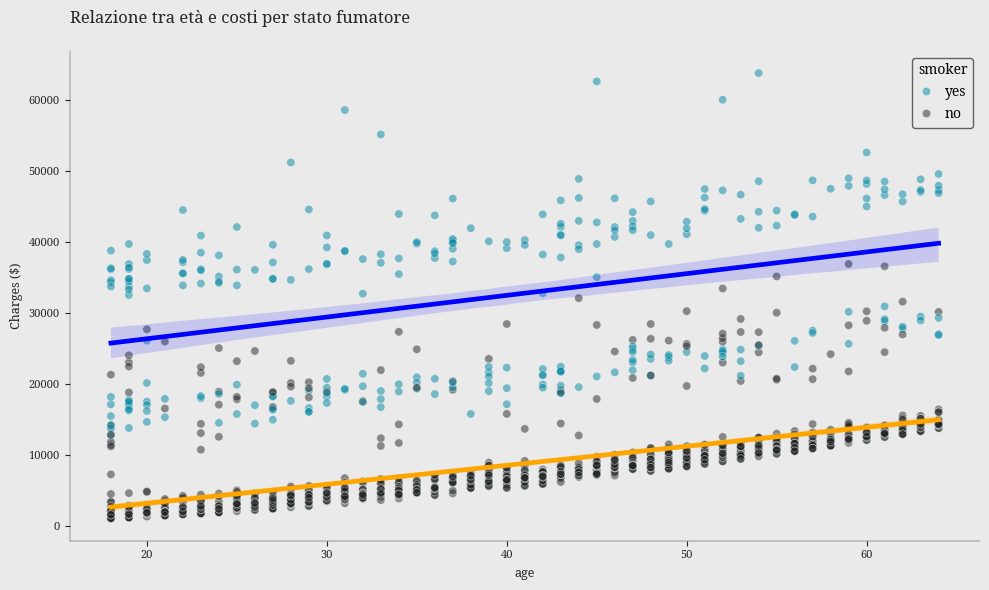


Test di Shapiro-Wilk per southwest:
Statistica: 0.7843
p-value: 0.0000

Test di Shapiro-Wilk per southeast:
Statistica: 0.8242
p-value: 0.0000

Test di Shapiro-Wilk per northwest:
Statistica: 0.8128
p-value: 0.0000

Test di Shapiro-Wilk per northeast:
Statistica: 0.8353
p-value: 0.0000

Test di Levene per l'omogeneità della varianza:
Statistica: 5.5600
p-value: 0.0009


TypeError: probplot() got an unexpected keyword argument 'color'

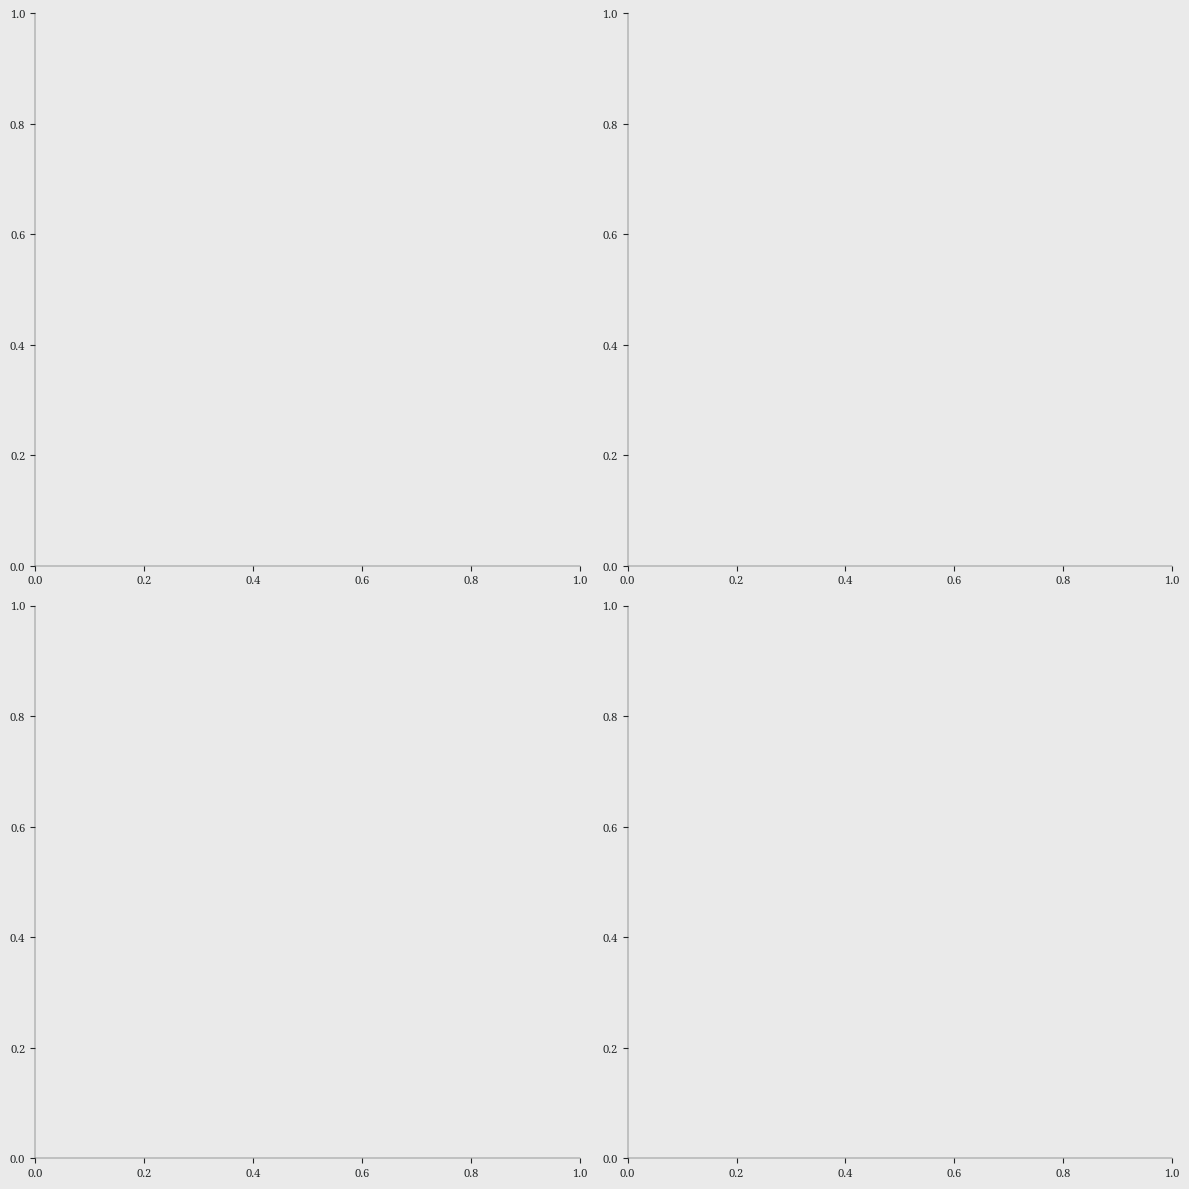

In [6]:
# Calcolo statistiche descrittive
region_stats = df.groupby('region')['charges'].describe()
print("Statistiche descrittive per regione:")
print(region_stats)

# Visualizzazione con boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='charges', data=df)
plt.title('Distribuzione dei costi per regione')
plt.ylabel('Charges ($)')
plt.show()

# Esecuzione one-way ANOVA
regions = [group for name, group in df.groupby('region')['charges']]
f_statistic, p_value = stats.f_oneway(*regions)

print("\nRisultati One-way ANOVA per regione:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Test di Tukey per confronti multipli
tukey = pairwise_tukeyhsd(df['charges'], df['region'])
print("\nRisultati test di Tukey:")
print(tukey)

# 2. Two-way ANOVA: Charges by Region and Smoker
#---------------------------------------------

# Creazione del modello
model = ols('charges ~ C(region) + C(smoker) + C(region):C(smoker)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nRisultati Two-way ANOVA:")
print(anova_table)

# Visualizzazione dell'interazione
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='charges', hue='smoker', data=df)
plt.title('Distribuzione dei costi per regione e stato fumatore')
plt.ylabel('Charges ($)')
plt.show()

# Plot dell'interazione
plt.figure(figsize=(10, 6))
interaction_data = df.groupby(['region', 'smoker'])['charges'].mean().unstack()
interaction_data.plot(marker='o')
plt.title('Plot di interazione: Region x Smoker')
plt.ylabel('Media delle charges ($)')
plt.grid(True)
plt.show()

# 3. ANCOVA: Charges by Smoker Status with Age as covariate
#-------------------------------------------------------

# Creazione del modello ANCOVA
ancova_model = ols('charges ~ C(smoker) + age', data=df).fit()
ancova_table = sm.stats.anova_lm(ancova_model, typ=2)
print("\nRisultati ANCOVA:")
print(ancova_table)

# Visualizzazione della relazione tra age e charges per fumatori e non fumatori
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='charges', hue='smoker', alpha=0.5)
sns.regplot(data=df[df['smoker']=='yes'], x='age', y='charges', scatter=False, color='blue')
sns.regplot(data=df[df['smoker']=='no'], x='age', y='charges', scatter=False, color='orange')
plt.title('Relazione tra età e costi per stato fumatore')
plt.ylabel('Charges ($)')
plt.show()

# 4. Assunzioni ANOVA
#-------------------

# Test di normalità per ogni gruppo
for region in df['region'].unique():
    stat, p_value = stats.shapiro(df[df['region'] == region]['charges'])
    print(f"\nTest di Shapiro-Wilk per {region}:")
    print(f"Statistica: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")

# Test di Levene per l'omogeneità della varianza
stat, p_value = stats.levene(*regions)
print("\nTest di Levene per l'omogeneità della varianza:")
print(f"Statistica: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Q-Q plot per ogni regione
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for idx, region in enumerate(df['region'].unique()):
    stats.probplot(df[df['region'] == region]['charges'], dist="norm", plot=axes[idx],color='#0085a1')
    axes[idx].set_title(f'Q-Q Plot per {region}')

plt.tight_layout()
plt.show()
